# Notebook 2 
## Sleep Detection - Model Training
In <b>Notebook 1 Sleep Detection - EDA</b> we have:
- explored the data to see if values are as expected from the description,
- checked if we have missing values,
- calculated correlations and saved highly correlated features into a file -> <b>"features_to_exclude.txt"</b>

In this notebook we continue with:
- defining our metrics,
- shuffle the data and split into training, validation and test set,
- training the first basic Decision Tree model,
- tuning Decision Tree hyperparameters,
- training and tuning XGBoost model.

In [36]:
import pandas as pd
import numpy as np
import datetime
import pickle
import matplotlib.pyplot as plt

import polars as pl
pl.Config.set_fmt_str_lengths(100)

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text

import xgboost as xgb
from xgboost import plot_importance

from helpers import create_rolling_features, concat_in_order, plot_data

#### Loading the dataset
- Load and check it again, first few rows and if it contains nulls.

In [37]:
train_data_file = 'data/sleep_data_120series_7days.csv'
df = pl.read_csv(train_data_file, dtypes={
    "dt_minute":pl.Datetime
}).sort(by=["series_id","dt_minute"])

In [38]:
df.head()

shape: (5, 6)
┌──────────────┬──────┬─────────────────────┬────────┬──────┬────────┐
│ series_id    ┆ step ┆ dt_minute           ┆ anglez ┆ enmo ┆ target │
│ ---          ┆ ---  ┆ ---                 ┆ ---    ┆ ---  ┆ ---    │
│ str          ┆ i64  ┆ datetime[μs]        ┆ i64    ┆ i64  ┆ i64    │
╞══════════════╪══════╪═════════════════════╪════════╪══════╪════════╡
│ 038441c925bb ┆ 0    ┆ 2018-08-14 15:30:00 ┆ 2      ┆ 21   ┆ 0      │
│ 038441c925bb ┆ 12   ┆ 2018-08-14 15:31:00 ┆ 27     ┆ 19   ┆ 0      │
│ 038441c925bb ┆ 24   ┆ 2018-08-14 15:32:00 ┆ -46    ┆ 17   ┆ 0      │
│ 038441c925bb ┆ 36   ┆ 2018-08-14 15:33:00 ┆ -79    ┆ 13   ┆ 0      │
│ 038441c925bb ┆ 48   ┆ 2018-08-14 15:34:00 ┆ -79    ┆ 13   ┆ 0      │
└──────────────┴──────┴─────────────────────┴────────┴──────┴────────┘

In [39]:
df.select(pl.all().is_null().sum())

shape: (1, 6)
┌───────────┬──────┬───────────┬────────┬──────┬────────┐
│ series_id ┆ step ┆ dt_minute ┆ anglez ┆ enmo ┆ target │
│ ---       ┆ ---  ┆ ---       ┆ ---    ┆ ---  ┆ ---    │
│ u32       ┆ u32  ┆ u32       ┆ u32    ┆ u32  ┆ u32    │
╞═══════════╪══════╪═══════════╪════════╪══════╪════════╡
│ 0         ┆ 0    ┆ 0         ┆ 0      ┆ 0    ┆ 0      │
└───────────┴──────┴───────────┴────────┴──────┴────────┘

#### Create sleeping time features

In [40]:
df = df.with_columns(
    pl.col('dt_minute').dt.hour().alias('hour')
)

In [41]:
def create_sleeping_time_vars(df):
    df = df.with_columns(
        pl.when(pl.col("hour").is_in([22,23,0,1,2,3,4,5,6,7,8]))
        .then(1)
        .otherwise(0)
        .alias('night')
    )
    return df

In [42]:
df = create_sleeping_time_vars(df)

In [43]:
df.head()

shape: (5, 8)
┌──────────────┬──────┬─────────────────────┬────────┬──────┬────────┬──────┬───────┐
│ series_id    ┆ step ┆ dt_minute           ┆ anglez ┆ enmo ┆ target ┆ hour ┆ night │
│ ---          ┆ ---  ┆ ---                 ┆ ---    ┆ ---  ┆ ---    ┆ ---  ┆ ---   │
│ str          ┆ i64  ┆ datetime[μs]        ┆ i64    ┆ i64  ┆ i64    ┆ u32  ┆ i32   │
╞══════════════╪══════╪═════════════════════╪════════╪══════╪════════╪══════╪═══════╡
│ 038441c925bb ┆ 0    ┆ 2018-08-14 15:30:00 ┆ 2      ┆ 21   ┆ 0      ┆ 15   ┆ 0     │
│ 038441c925bb ┆ 12   ┆ 2018-08-14 15:31:00 ┆ 27     ┆ 19   ┆ 0      ┆ 15   ┆ 0     │
│ 038441c925bb ┆ 24   ┆ 2018-08-14 15:32:00 ┆ -46    ┆ 17   ┆ 0      ┆ 15   ┆ 0     │
│ 038441c925bb ┆ 36   ┆ 2018-08-14 15:33:00 ┆ -79    ┆ 13   ┆ 0      ┆ 15   ┆ 0     │
│ 038441c925bb ┆ 48   ┆ 2018-08-14 15:34:00 ┆ -79    ┆ 13   ┆ 0      ┆ 15   ┆ 0     │
└──────────────┴──────┴─────────────────────┴────────┴──────┴────────┴──────┴───────┘

#### Calculate rolling features

In [44]:
df = create_rolling_features(df)

In [45]:
df.head()

shape: (5, 56)
┌─────────────┬──────┬────────────┬────────┬───┬────────────┬────────────┬────────────┬────────────┐
│ series_id   ┆ step ┆ dt_minute  ┆ anglez ┆ … ┆ enmo_diffs ┆ anglez_dif ┆ enmo_diffs ┆ anglez_dif │
│ ---         ┆ ---  ┆ ---        ┆ ---    ┆   ┆ _sum_div_m ┆ fs_sum_div ┆ _sum_div_m ┆ fs_sum_div │
│ str         ┆ i64  ┆ datetime[μ ┆ i64    ┆   ┆ ax_min_180 ┆ _max_min_1 ┆ ax_min_480 ┆ _max_min_4 │
│             ┆      ┆ s]         ┆        ┆   ┆ m          ┆ 80m        ┆ m          ┆ 80m        │
│             ┆      ┆            ┆        ┆   ┆ ---        ┆ ---        ┆ ---        ┆ ---        │
│             ┆      ┆            ┆        ┆   ┆ f64        ┆ f64        ┆ f64        ┆ f64        │
╞═════════════╪══════╪════════════╪════════╪═══╪════════════╪════════════╪════════════╪════════════╡
│ 038441c925b ┆ 0    ┆ 2018-08-14 ┆ 2      ┆ … ┆ 0.14658    ┆ 0.092658   ┆ 0.110342   ┆ 0.083097   │
│ b           ┆      ┆ 15:30:00   ┆        ┆   ┆            ┆            ┆            ┆            │
│ 038441c925b ┆ 12   ┆ 2018-08-14 ┆ 27     ┆ … ┆ 0.145917   ┆ 0.08795    ┆ 0.110199   ┆ 0.083738   │
│ b           ┆      ┆ 15:31:00   ┆        ┆   ┆            ┆            ┆            ┆            │
│ 038441c925b ┆ 24   ┆ 2018-08-14 ┆ -46    ┆ … ┆ 0.14513    ┆ 0.087486   ┆ 0.110037   ┆ 0.082568   │
│ b           ┆      ┆ 15:32:00   ┆        ┆   ┆            ┆            ┆            ┆            │
│ 038441c925b ┆ 36   ┆ 2018-08-14 ┆ -79    ┆ … ┆ 0.144332   ┆ 0.085707   ┆ 0.109857   ┆ 0.082462   │
│ b           ┆      ┆ 15:33:00   ┆        ┆   ┆            ┆            ┆            ┆            │
│ 038441c925b ┆ 48   ┆ 2018-08-14 ┆ -79    ┆ … ┆ 0.143632   ┆ 0.086682   ┆ 0.10964    ┆ 0.082641   │
│ b           ┆      ┆ 15:34:00   ┆        ┆   ┆            ┆            ┆            ┆            │
└─────────────┴──────┴────────────┴────────┴───┴────────────┴────────────┴────────────┴────────────┘

### Split into training, validation and test set.

In [99]:
# We need to split by series_id to be able to calculate rolling variables
# Shuffle series id's
series_ids_shuffle = df["series_id"].unique().sort().shuffle(seed=4)

# Determine sizes
test_val_set_size = int(series_ids_shuffle.shape[0] * 0.2)
train_set_size = series_ids_shuffle.shape[0] - 2 * test_val_set_size

# Select sets
df_train_night_ids = series_ids_shuffle[:train_set_size]
df_val_night_ids = series_ids_shuffle[train_set_size:train_set_size+test_val_set_size]
df_test_night_ids = series_ids_shuffle[train_set_size+test_val_set_size:]

df_train = df.filter(pl.col('series_id').is_in(df_train_night_ids))
df_val = df.filter(pl.col('series_id').is_in(df_val_night_ids))
df_test = df.filter(pl.col('series_id').is_in(df_test_night_ids))

#### Check if tarin, val and test sets contains all three target values

In [100]:
df_train.group_by(["target"]).agg(pl.col("dt_minute").count())

shape: (3, 2)
┌────────┬───────────┐
│ target ┆ dt_minute │
│ ---    ┆ ---       │
│ i64    ┆ u32       │
╞════════╪═══════════╡
│ 0      ┆ 388184    │
│ 1      ┆ 193805    │
│ 2      ┆ 128093    │
└────────┴───────────┘

In [101]:
df_val.group_by(["target"]).agg(pl.col("dt_minute").count())

shape: (3, 2)
┌────────┬───────────┐
│ target ┆ dt_minute │
│ ---    ┆ ---       │
│ i64    ┆ u32       │
╞════════╪═══════════╡
│ 0      ┆ 137682    │
│ 1      ┆ 73263     │
│ 2      ┆ 30353     │
└────────┴───────────┘

In [102]:
df_test.group_by(["target"]).agg(pl.col("dt_minute").count())

shape: (3, 2)
┌────────┬───────────┐
│ target ┆ dt_minute │
│ ---    ┆ ---       │
│ i64    ┆ u32       │
╞════════╪═══════════╡
│ 0      ┆ 128407    │
│ 1      ┆ 67842     │
│ 2      ┆ 45695     │
└────────┴───────────┘

In [103]:
df_train = create_rolling_features(df_train)
df_val = create_rolling_features(df_val)
df_test = create_rolling_features(df_test)

#### Read features to exclude that are highly correlated with some other features
- We have found them in <b>sleep_detection_eda.ipynb notebook</b>.

In [104]:
with open('data/features_to_exclude.txt') as f:
    vars_to_exclude = [line.rstrip() for line in f]

vars_to_exclude

['enmo_15m_max',
 'enmo_60m_max',
 'enmo_180m_max',
 'enmo_480m_max',
 'enmo_diffs_15m_sum',
 'enmo_diffs_60m_sum',
 'enmo_diffs_180m_sum',
 'enmo_diffs_480m_sum',
 'anglez',
 'anglez_15m_mean',
 'anglez_15m_std',
 'anglez_diffs_180m_sum',
 'enmo_15m_mean',
 'enmo_60m_mean',
 'enmo_60m_mean',
 'enmo_180m_mean',
 'enmo_480m_mean']

In [105]:
df_train = df_train.drop(vars_to_exclude)
df_val = df_val.drop(vars_to_exclude)
df_test = df_test.drop(vars_to_exclude)

### Transform to pandas

In [106]:
df_train_pd = df_train.to_pandas()
df_val_pd = df_val.to_pandas()
df_test_pd = df_test.to_pandas()

labels = "target"
y_train = df_train_pd[labels].values
y_val = df_val_pd[labels].values
y_test = df_test_pd[labels].values

del df_train_pd[labels] 
del df_val_pd[labels]
del df_test_pd[labels]

features = [f for f in df_train_pd.columns if f not in ["dt_minute","step","series_id"]]
features

['enmo',
 'hour',
 'night',
 'enmo_15m_min',
 'enmo_15m_std',
 'anglez_15m_max',
 'anglez_15m_min',
 'anglez_diffs_15m_sum',
 'enmo_60m_min',
 'enmo_60m_std',
 'anglez_60m_mean',
 'anglez_60m_max',
 'anglez_60m_min',
 'anglez_60m_std',
 'anglez_diffs_60m_sum',
 'enmo_180m_min',
 'enmo_180m_std',
 'anglez_180m_mean',
 'anglez_180m_max',
 'anglez_180m_min',
 'anglez_180m_std',
 'enmo_480m_min',
 'enmo_480m_std',
 'anglez_480m_mean',
 'anglez_480m_max',
 'anglez_480m_min',
 'anglez_480m_std',
 'anglez_diffs_480m_sum',
 'enmo_diffs_sum_div_max_min_15m',
 'anglez_diffs_sum_div_max_min_15m',
 'enmo_diffs_sum_div_max_min_60m',
 'anglez_diffs_sum_div_max_min_60m',
 'enmo_diffs_sum_div_max_min_180m',
 'anglez_diffs_sum_div_max_min_180m',
 'enmo_diffs_sum_div_max_min_480m',
 'anglez_diffs_sum_div_max_min_480m']

### Transform categorical variables (actyally only one - "hour") into one-hot-encoded variables.

In [107]:
X_train = df_train_pd[features]
X_val = df_val_pd[features]
X_test = df_test_pd[features]

## Metrics
- This is a classification problem so we will calculate accuracy.
- However, our goal is to determine <b>sleep state</b> so we will also calculate precision, recall and F1 score for sleep.
- Our priority will be <b>sleep F1 score metric</b>.  

#### Precision, recall and F1 score

In [108]:
def calculate_metrics(y_pred,y_val,target):
    precision = sum((y_pred==y_val) & (y_val==target)) / sum(y_pred==target)
    recall = sum((y_pred==y_val) & (y_val==target)) / sum(y_val==target)
    f1_score = 2 / ((1/precision) + (1/recall))
    return precision, recall, f1_score

## Model 1: Decision tree

Let's start with a very simple tree of depth 2.

In [109]:
model = DecisionTreeClassifier(max_depth=3, random_state=3)
model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=3)

In [110]:
model.classes_

array([0, 1, 2])

In [68]:
print(export_text(model, feature_names=features))

|--- enmo_60m_std <= 14.40
|   |--- anglez_diffs_480m_sum <= 8.59
|   |   |--- anglez_180m_max <= 80.50
|   |   |   |--- class: 2
|   |   |--- anglez_180m_max >  80.50
|   |   |   |--- class: 2
|   |--- anglez_diffs_480m_sum >  8.59
|   |   |--- night <= 0.50
|   |   |   |--- class: 0
|   |   |--- night >  0.50
|   |   |   |--- class: 1
|--- enmo_60m_std >  14.40
|   |--- anglez_diffs_480m_sum <= 7.84
|   |   |--- enmo_60m_min <= 16.50
|   |   |   |--- class: 2
|   |   |--- enmo_60m_min >  16.50
|   |   |   |--- class: 2
|   |--- anglez_diffs_480m_sum >  7.84
|   |   |--- hour <= 6.50
|   |   |   |--- class: 1
|   |   |--- hour >  6.50
|   |   |   |--- class: 0



We can see that the most importnat features are:
- enmo_60m_std
- anglez_diffs_480m_sum
- anglez_180m_max
- night
- enmo_60m_min
- hour

In [69]:
y_pred = model.predict(X_val)

In [70]:
accuracy = sum(y_val == y_pred) / y_pred.size
sleep_precision, sleep_recall, sleep_f1_score = calculate_metrics(y_pred,y_val,target=1)

In [72]:
print(
    f"Accuracy: \t\t {accuracy.round(3)}"
    f"\nSleep precision: \t {sleep_precision.round(3)}" 
    f"\nSleep recall: \t\t {sleep_recall.round(3)} "
    f"\nSleep F1 score: \t {sleep_f1_score.round(3)}"
)

Accuracy: 		 0.854
Sleep precision: 	 0.839
Sleep recall: 		 0.865 
Sleep F1 score: 	 0.852


We can see that even this simple tree gives us decent results.

However, we will try to improve.

### Decision tree - hyperparameter tuning
- Parameters that will be tuned:
    - max_depth
    - min_samples_split 

In [41]:
max_depth_s = [2,6,8,10]
min_samples_split_s = [150, 200, 250]

In [42]:
results = []
for max_depth in max_depth_s:
    for min_samples_split in min_samples_split_s:
        print(f"growing tree with max_depth: {max_depth} and min_sampes_split: {min_samples_split} ...")
        model = DecisionTreeClassifier(max_depth=max_depth, min_samples_split=min_samples_split, random_state=1)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        accuracy = sum(y_val == y_pred) / y_pred.size
        sleep_precision, sleep_recall, sleep_f1_score = calculate_metrics(target=1)
        results.append({
            "max_depth": max_depth,
            "min_samples_split": min_samples_split,
            "accuracy": accuracy,
            "sleep_precision": sleep_precision,
            "sleep_recall": sleep_recall,
            "sleep_f1_score": sleep_f1_score
        })

growing tree with max_depth: 2 and min_sampes_split: 150 ...
growing tree with max_depth: 2 and min_sampes_split: 200 ...
growing tree with max_depth: 2 and min_sampes_split: 250 ...
growing tree with max_depth: 6 and min_sampes_split: 150 ...
growing tree with max_depth: 6 and min_sampes_split: 200 ...
growing tree with max_depth: 6 and min_sampes_split: 250 ...
growing tree with max_depth: 8 and min_sampes_split: 150 ...
growing tree with max_depth: 8 and min_sampes_split: 200 ...
growing tree with max_depth: 8 and min_sampes_split: 250 ...
growing tree with max_depth: 10 and min_sampes_split: 150 ...
growing tree with max_depth: 10 and min_sampes_split: 200 ...
growing tree with max_depth: 10 and min_sampes_split: 250 ...


In [43]:
results_pd = pd.DataFrame(results).set_index(["max_depth","min_samples_split"])

In [44]:
results_pd.sort_values(by="sleep_f1_score", ascending=False).style.format(precision=4).background_gradient(subset=["sleep_f1_score"], axis=0)

The best sleep F1 score is obtained for decision tree with max_depth=8 and min_sample_split=200.

Our best sleep F1 score is equal to <b>0.8781<b>.

### Decision Tree - best probability threshold 
- We plot precision and recall for different probability thresholds to see which threshold is optimal.

In [82]:
model = DecisionTreeClassifier(max_depth=8, min_samples_split=200, random_state=1)
model.fit(X_train, y_train)
y_proba = model.predict_proba(X_val)
y_proba_sleep = y_proba[:,1]

In [83]:
thrs = np.linspace(0,0.99,100)
thrs

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99])

In [89]:
precision_recall = {}
for t in thrs:
    y_pred = (y_proba_sleep>t).astype(int)
    sleep_precision, sleep_recall, sleep_f1_score = calculate_metrics(y_pred,y_val,target=1)
    precision_recall[t] = [sleep_precision, sleep_recall]

In [90]:
df_p_r = pd.DataFrame(precision_recall).T
df_p_r.columns = ["precision", "recall"]

<Figure size 600x600 with 0 Axes>

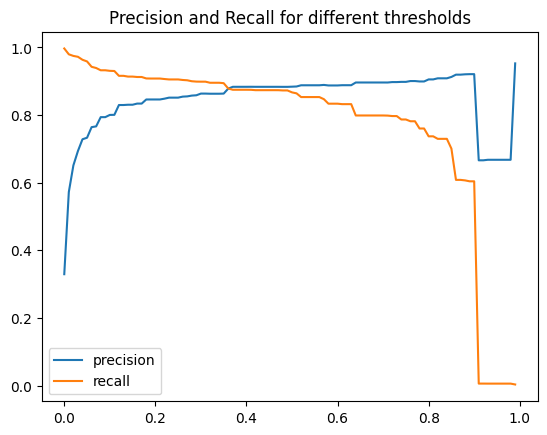

In [91]:
plt.figure(figsize=(6, 6));
df_p_r.plot();
plt.title("Precision and Recall for different thresholds");

Summary
- Threshold form about 3.9 to 5 should give us similar results.
- Let's stay with 0.5.

## Model 2: XGBoost
- Let's train first a model checking how mnay num_boost_round will be optimal.
- Then we will tune hyperparamaters.

In [23]:
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)
dtest = xgb.DMatrix(X_test, label=y_test, feature_names=features)

In [24]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [110]:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    'objective': 'multi:softprob', 
    'num_class': 3,
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1,
    'verbosity': 1
}

In [129]:
model = xgb.train(
    xgb_params, 
    dtrain,
    evals=watchlist,
    verbose_eval=10, #print every 10 step
    num_boost_round=50 # 30 is optimal - with more we overfit
)

[0]	train-auc:0.93901	val-auc:0.91900
[10]	train-auc:0.97765	val-auc:0.92623
[20]	train-auc:0.98742	val-auc:0.92296
[30]	train-auc:0.99240	val-auc:0.92113
[40]	train-auc:0.99533	val-auc:0.92085
[49]	train-auc:0.99672	val-auc:0.92096


In [130]:
y_pred_proba = model.predict(dval)
y_pred_proba

array([[0.81801087, 0.08234242, 0.09964678],
       [0.84379447, 0.08349394, 0.07271165],
       [0.84008867, 0.08839852, 0.07151283],
       ...,
       [0.63327444, 0.22146748, 0.14525814],
       [0.6863007 , 0.20312554, 0.11057376],
       [0.7299095 , 0.15249072, 0.11759982]], dtype=float32)

In [131]:
y_pred = np.argmax(y_pred_proba, axis=1)
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [132]:
accuracy = sum(y_val == y_pred) / y_pred.size
sleep_precision, sleep_recall, sleep_f1_score = calculate_metrics(y_pred,y_val,target=1)

In [133]:
print(
    f"Accuracy: \t\t {accuracy.round(3)}"
    f"\nSleep precision: \t {sleep_precision.round(3)}" 
    f"\nSleep recall: \t\t {sleep_recall.round(3)} "
    f"\nSleep F1 score: \t {sleep_f1_score.round(3)}"
)

Accuracy: 		 0.859
Sleep precision: 	 0.885
Sleep recall: 		 0.918 
Sleep F1 score: 	 0.901


### XGBoost - hyperparameters tuning

In [134]:
max_depth_s = [2,6,8]
min_child_weight_s = [200, 250,300]

In [135]:
results = []
for max_depth in max_depth_s:
    for min_child_weight in min_child_weight_s:
        xgb_params = {
            'eta': 0.3, 
            'max_depth': max_depth,
            'min_child_weight': min_child_weight,
            'objective': 'multi:softprob', 
            'num_class': 3,
            'eval_metric': 'auc',
            'nthread': 8,
            'seed': 1,
            'verbosity': 1
        }
        print(f"training xgboost with max_depth: {max_depth} and min_child_weight: {min_samples_split} ...")
        model = xgb.train(
            xgb_params, 
            dtrain,
            evals=watchlist,
            verbose_eval=10, #print every 10 step
            num_boost_round=50 # with more we overfit
        )
        
        y_pred_proba = model.predict(dval)
        y_pred = np.argmax(y_pred_proba, axis=1)

        accuracy = sum(y_val == y_pred) / y_pred.size
        sleep_precision, sleep_recall, sleep_f1_score = calculate_metrics(y_pred,y_val,target=1)
        results.append({
            "max_depth": max_depth,
            "min_child_weight": min_child_weight,
            "accuracy": accuracy,
            "sleep_precision": sleep_precision,
            "sleep_recall": sleep_recall,
            "sleep_f1_score": sleep_f1_score
        })

training xgboost with max_depth: 2 and min_child_weight: 250 ...
[0]	train-auc:0.86874	val-auc:0.89852
[10]	train-auc:0.91811	val-auc:0.92633
[20]	train-auc:0.92742	val-auc:0.92691
[30]	train-auc:0.93128	val-auc:0.92632
[40]	train-auc:0.93457	val-auc:0.92569
[49]	train-auc:0.93718	val-auc:0.92568
training xgboost with max_depth: 2 and min_child_weight: 250 ...
[0]	train-auc:0.86874	val-auc:0.89852
[10]	train-auc:0.91811	val-auc:0.92633
[20]	train-auc:0.92680	val-auc:0.92721
[30]	train-auc:0.93169	val-auc:0.92631
[40]	train-auc:0.93471	val-auc:0.92608
[49]	train-auc:0.93728	val-auc:0.92555
training xgboost with max_depth: 2 and min_child_weight: 250 ...
[0]	train-auc:0.86874	val-auc:0.89852
[10]	train-auc:0.91811	val-auc:0.92633
[20]	train-auc:0.92674	val-auc:0.92717
[30]	train-auc:0.93129	val-auc:0.92659
[40]	train-auc:0.93449	val-auc:0.92545
[49]	train-auc:0.93672	val-auc:0.92522
training xgboost with max_depth: 6 and min_child_weight: 250 ...
[0]	train-auc:0.92625	val-auc:0.92074
[10

In [136]:
results_pd = pd.DataFrame(results).set_index(["max_depth","min_child_weight"])

In [137]:
results_pd.sort_values(by="sleep_f1_score", ascending=False).style.format(precision=4).background_gradient(subset=["sleep_f1_score"], axis=0)

The best sleep F1 score is obtained for XGBoost model with max_depth=6 and min_chimld_weight=250.

Our best sleep F1 score is equal to <b>0.9014</b>. 
- That's an improvement from the best DT of 0.8781.

### Feature importance

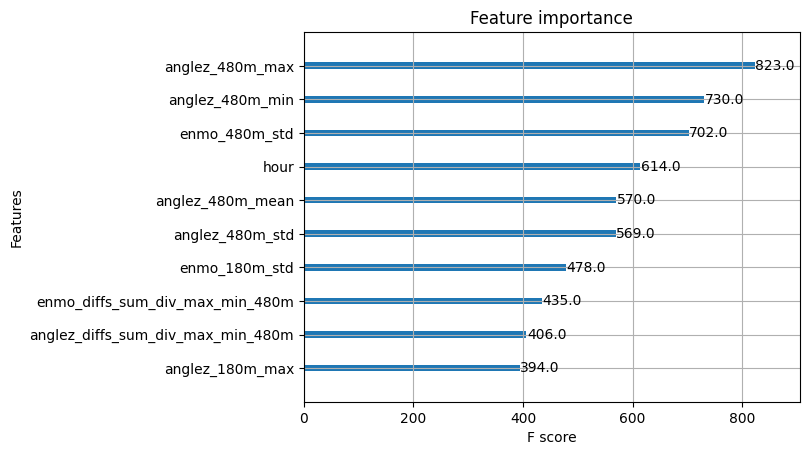

In [151]:
plot_importance(model, max_num_features=10, importance_type="weight");

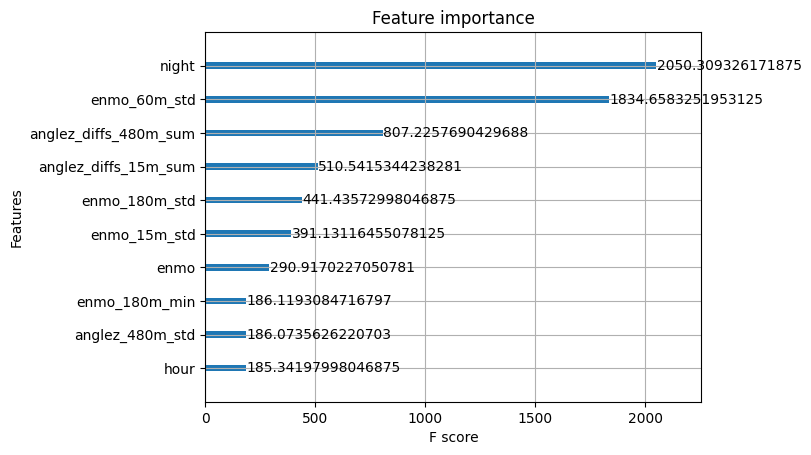

In [148]:
plot_importance(model, max_num_features=10, importance_type="gain");

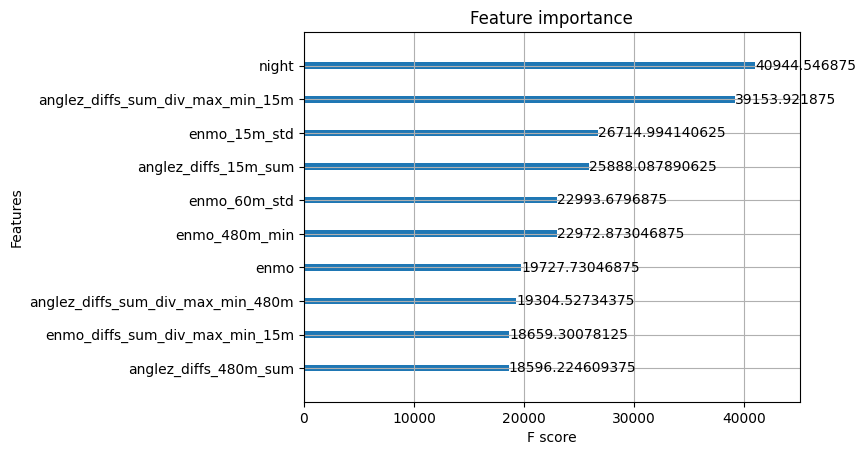

In [154]:
plot_importance(model, max_num_features=10, importance_type="cover");

In [155]:
features_importance_weight = model.get_score(importance_type='weight')
features_importance_gain = model.get_score(importance_type='gain')
features_importance_cover = model.get_score(importance_type='cover')

### Saving best model

In [167]:
model_file_name = "sleep_detection_model_xgb.bin"
pickle.dump(model, open(model_file_name, 'wb'))

Later to load it we can run the below code

```python
model_file_name = "sleep_detection_model_xgb.bin"
with open(model_file_name, 'rb') as mof_in:
    model = pickle.load(mof_in)
```

In [111]:
model_file_name = "sleep_detection_model_xgb.bin"
with open(model_file_name, 'rb') as mof_in:
    model = pickle.load(mof_in)

### Test set performance

In [112]:
y_test_proba = model.predict(dtest)
y_test_pred = np.argmax(y_test_proba, axis=1)

In [113]:
accuracy = sum(y_test == y_test_pred) / y_test_pred.size
sleep_precision, sleep_recall, sleep_f1_score = calculate_metrics(y_test_pred,y_test,target=1)

In [114]:
print(
    f"Accuracy: \t\t {accuracy.round(3)}"
    f"\nSleep precision: \t {sleep_precision.round(3)}" 
    f"\nSleep recall: \t\t {sleep_recall.round(3)} "
    f"\nSleep F1 score: \t {sleep_f1_score.round(3)}"
)

Accuracy: 		 0.815
Sleep precision: 	 0.869
Sleep recall: 		 0.936 
Sleep F1 score: 	 0.901


#### Summary
- Test set sleep F1 score is similar to the one of validation set.
- Recall is a bit higher and precision is a bit lower.
- Accuracy is a bit lower but this is not a large difference.

### Plotting test set predictions
- To visualise the results

In [115]:
df_test_pd["target"] = y_test
df_test_pd["prediction"] = y_test_pred
df_test_pd["probability"] = model.predict(dtest)[:,1]
df_test_pd["anglez"] = df.filter(pl.col("series_id").is_in(list(df_test_pd["series_id"].unique())))["anglez"]

In [116]:
df_test_pd.head()

series_id  step           dt_minute  enmo  hour  night  enmo_15m_min  \
0  038441c925bb     0 2018-08-14 15:30:00    21    15      0            12   
1  038441c925bb    12 2018-08-14 15:31:00    19    15      0            12   
2  038441c925bb    24 2018-08-14 15:32:00    17    15      0            12   
3  038441c925bb    36 2018-08-14 15:33:00    13    15      0            12   
4  038441c925bb    48 2018-08-14 15:34:00    13    15      0            12   

   enmo_15m_std  anglez_15m_max  anglez_15m_min  ...  \
0      3.505098              27             -79  ...   
1      3.345810              27             -80  ...   
2      3.274480              27             -80  ...   
3      3.196589              27             -80  ...   
4      3.117643              27             -80  ...   

   enmo_diffs_sum_div_max_min_60m  anglez_diffs_sum_div_max_min_60m  \
0                        0.181469                          0.133921   
1                        0.179911                          0.131774   
2                        0.177376                          0.129725   
3                        0.175977                          0.127857   
4                        0.173260                          0.125982   

   enmo_diffs_sum_div_max_min_180m  anglez_diffs_sum_div_max_min_180m  \
0                         0.146580                           0.092658   
1                         0.145917                           0.087950   
2                         0.145130                           0.087486   
3                         0.144332                           0.085707   
4                         0.143632                           0.086682   

   enmo_diffs_sum_div_max_min_480m  anglez_diffs_sum_div_max_min_480m  target  \
0                         0.110342                           0.083097       0   
1                         0.110199                           0.083738       0   
2                         0.110037                           0.082568       0   
3                         0.109857                           0.082462       0   
4                         0.109640                           0.082641       0   

   prediction  probability  anglez  
0           0     0.013568       2  
1           0     0.010801      27  
2           0     0.018797     -46  
3           2     0.021085     -79  
4           0     0.019279     -79  

[5 rows x 43 columns]

038441c925bb


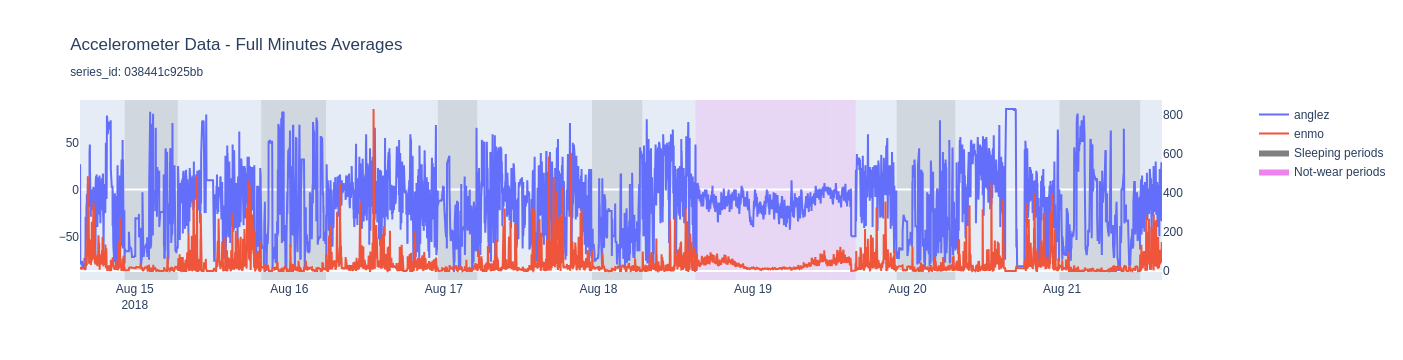

In [170]:
plot_data(pl.from_pandas(df_test_pd), sorted(df_test_pd["series_id"].unique())[0], labels="target")

038441c925bb


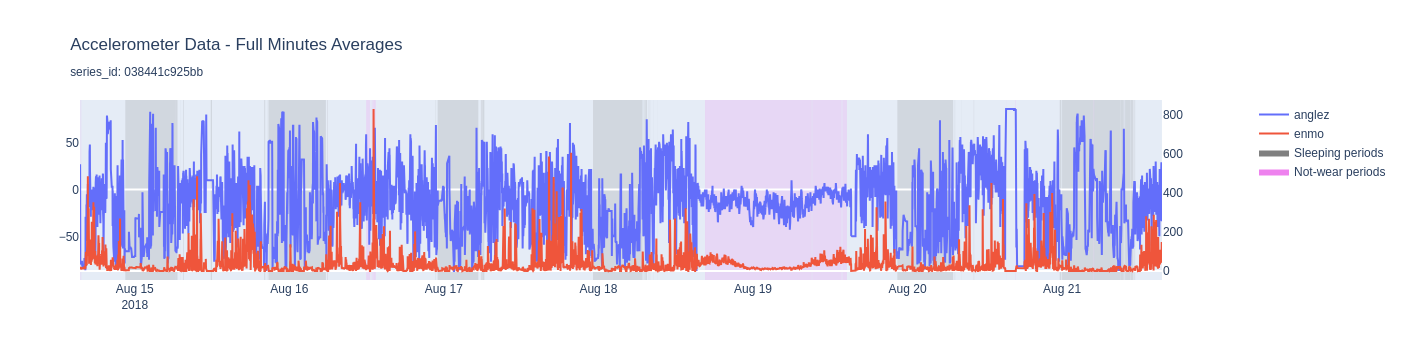

In [169]:
plot_data(pl.from_pandas(df_test_pd), sorted(df_test_pd["series_id"].unique())[0], labels="prediction")

### Cleaning predictions
- We can improve our predictions by smoothing time series.
- Short breaks in sleep will be mark as sleep as well.
- Single short sleep periods will be ignored.

In [223]:
def clean_predictions(df):

    df_pl = pl.from_pandas(df)

    series_reults = []
    
    for s in df_pl["series_id"].unique():
        df_s = df_pl.filter(pl.col('series_id')==s).sort(by='dt_minute')

         # Mark short breaks in sleep as sleep
        df_s = df_s.sort(by='dt_minute')
        df_s = df_s.sort(by=['series_id','dt_minute']).with_columns(
            pl.col('prediction').rolling_min(window_size=10, center=False).alias('long_sleep'),
            pl.col('step').rolling_min(window_size=10, center=False).alias('long_sleep_start'),
            pl.col('step').rolling_max(window_size=10, center=False).alias('long_sleep_end')
        )

        # Clean onsets - they all start 9 min late
        pred_onsets = df_s.filter((df_s['long_sleep'].diff()!=0)&(df_s['long_sleep']==1))['long_sleep_start'].to_list()
        for onset in pred_onsets:
            df_s = df_s.with_columns(
             pl.when((pl.col('step')<=onset+12*9)&(pl.col('step')>=onset)).then(1)
            .otherwise(pl.col('long_sleep'))
            .alias('long_sleep'))
            
        pred_onsets = df_s.filter((df_s['long_sleep'].diff()!=0)&(df_s['long_sleep']==1))['step'].to_list()
        pred_wakeups = df_s.filter((df_s['long_sleep'].diff()==-1)&(df_s['long_sleep']==0)|(df_s['long_sleep'].diff()==1)&(df_s['long_sleep']==2))['step'].to_list() 
        
        # mark breaks in sleep that are less or equal to 30 min as sleep
        short_break_periods = [(wakeup, onset) for onset, wakeup in zip(pred_onsets[1:], pred_wakeups[:-1]) if onset - wakeup <= 12 * 30]
        
        for break_start, break_end in short_break_periods:
            df_s = df_s.with_columns(
             pl.when((pl.col('step')>=break_start)&(pl.col('step')<=break_end)).then(1)
            .otherwise(pl.col('long_sleep'))
            .alias('long_sleep'))

        # Ignore signle short sleep times
        pred_onsets = df_s.filter((df_s['long_sleep'].diff()!=0)&(df_s['long_sleep']==1))['long_sleep_start'].to_list()
        pred_wakeups = df_s.filter((df_s['long_sleep'].diff()==-1)&(df_s['long_sleep']==0)|(df_s['long_sleep'].diff()==1)&(df_s['long_sleep']==2))['long_sleep_end'].to_list() 
        short_sleep_times = [(onset, wakeup) for onset, wakeup in zip(pred_onsets, pred_wakeups) if wakeup - onset <= 12 * 30]
        for onset, wakeup in short_sleep_times:
            df_s = df_s.with_columns(
             pl.when((pl.col('step')>=onset)&(pl.col('step')<=wakeup)).then(0)
            .otherwise(pl.col('long_sleep'))
            .alias('long_sleep'))
        
        series_reults.append(df_s)
    
    df = pl.concat(series_reults).to_pandas()
    return df


In [224]:
df_test_pd = clean_predictions(df_test_pd)

In [225]:
y_test_pred_clean = df_test_pd["long_sleep"]
accuracy = sum(y_test == y_test_pred) / y_test_pred.size
sleep_precision, sleep_recall, sleep_f1_score = calculate_metrics(y_test_pred,y_test,target=1)

In [226]:
print(
    f"Accuracy: \t\t {accuracy.round(3)}"
    f"\nSleep precision: \t {sleep_precision.round(3)}" 
    f"\nSleep recall: \t\t {sleep_recall.round(3)} "
    f"\nSleep F1 score: \t {sleep_f1_score.round(3)}"
)

Accuracy: 		 0.815
Sleep precision: 	 0.869
Sleep recall: 		 0.936 
Sleep F1 score: 	 0.901


038441c925bb


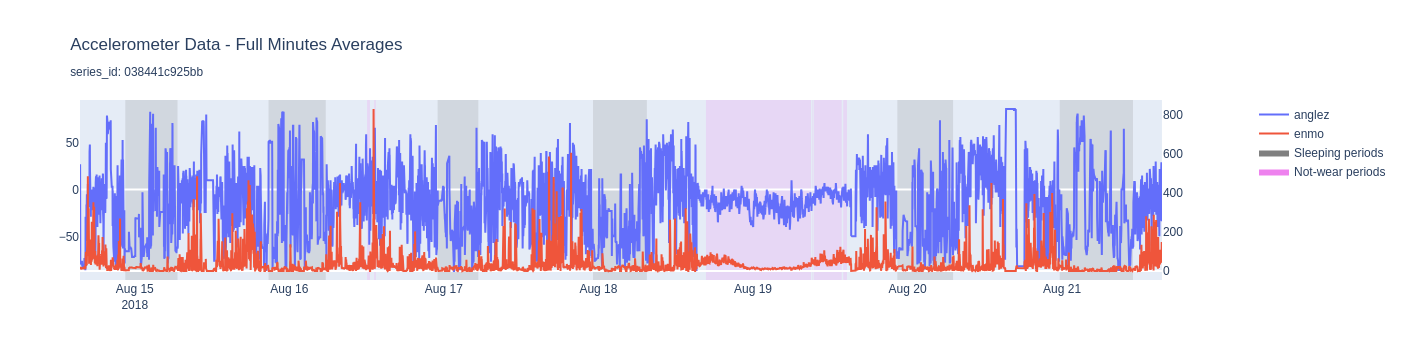

In [228]:
plot_data(pl.from_pandas(df_test_pd), sorted(df_test_pd["series_id"].unique())[0], labels="long_sleep")

In [231]:
def get_events(df, idx, target='long_sleep'):
    df = df.filter(pl.col("series_id")==idx)
    events = pl.DataFrame(schema={'night_count':int, 'series_id':str, 'step':int, 'timestamp': pl.Datetime,'event':str, 'score':float})
    
    pred_onsets = df.filter((df[target].diff()!=0)&(df[target]==1))['step'].to_list()
    pred_wakeups = df.filter((df[target].diff()==-1)&(df[target]==0)|(df[target].diff()==1)&(df[target]==2))['step'].to_list()
    sleep_periods = [(onset, wakeup) for onset, wakeup in zip(pred_onsets, pred_wakeups)]

    night_count = 0
    for onset, wakeup in sleep_periods:
        night_count += 1
        # Scoring using mean probability over period
        score = df.filter((pl.col('step') >= onset) & (pl.col('step') <= wakeup))['probability'].mean()
        onset_time = df.filter(pl.col("step")==onset)["dt_minute"][0]
        wakeup_time = df.filter(pl.col("step")==wakeup)["dt_minute"][0]
        # Adding sleep event to dataframe
        events = events.vstack(pl.DataFrame().with_columns(
            pl.Series([night_count, night_count]).alias('night_count'), 
            pl.Series([idx, idx]).alias('series_id'), 
            pl.Series([onset, wakeup]).alias('step'),
            pl.Series([onset_time, wakeup_time]).alias('timestamp'),
            pl.Series(['onset', 'wakeup']).alias('event'),
            pl.Series([score, score]).alias('score')
        ))
    return events

In [235]:
events = get_events(pl.from_pandas(df_test_pd),"038441c925bb")
print("Predicted onsets and wakeups")
events

Predicted onsets and wakeups


shape: (12, 6)
┌─────────────┬──────────────┬────────┬─────────────────────┬────────┬──────────┐
│ night_count ┆ series_id    ┆ step   ┆ timestamp           ┆ event  ┆ score    │
│ ---         ┆ ---          ┆ ---    ┆ ---                 ┆ ---    ┆ ---      │
│ i64         ┆ str          ┆ i64    ┆ datetime[μs]        ┆ str    ┆ f64      │
╞═════════════╪══════════════╪════════╪═════════════════════╪════════╪══════════╡
│ 1           ┆ 038441c925bb ┆ 5064   ┆ 2018-08-14 22:32:00 ┆ onset  ┆ 0.909353 │
│ 1           ┆ 038441c925bb ┆ 10896  ┆ 2018-08-15 06:38:00 ┆ wakeup ┆ 0.909353 │
│ 2           ┆ 038441c925bb ┆ 21084  ┆ 2018-08-15 20:47:00 ┆ onset  ┆ 0.852451 │
│ 2           ┆ 038441c925bb ┆ 27468  ┆ 2018-08-16 05:39:00 ┆ wakeup ┆ 0.852451 │
│ …           ┆ …            ┆ …      ┆ …                   ┆ …      ┆ …        │
│ 5           ┆ 038441c925bb ┆ 91380  ┆ 2018-08-19 22:25:00 ┆ onset  ┆ 0.871282 │
│ 5           ┆ 038441c925bb ┆ 97608  ┆ 2018-08-20 07:04:00 ┆ wakeup ┆ 0.871282 │
│ 6           ┆ 038441c925bb ┆ 109536 ┆ 2018-08-20 23:38:00 ┆ onset  ┆ 0.817795 │
│ 6           ┆ 038441c925bb ┆ 117720 ┆ 2018-08-21 11:00:00 ┆ wakeup ┆ 0.817795 │
└─────────────┴──────────────┴────────┴─────────────────────┴────────┴──────────┘

In [234]:
events = get_events(pl.from_pandas(df_test_pd),"038441c925bb",target="target")
print("True onsets and wakeups")
events

True onsets and wakeups


shape: (12, 6)
┌─────────────┬──────────────┬────────┬─────────────────────┬────────┬──────────┐
│ night_count ┆ series_id    ┆ step   ┆ timestamp           ┆ event  ┆ score    │
│ ---         ┆ ---          ┆ ---    ┆ ---                 ┆ ---    ┆ ---      │
│ i64         ┆ str          ┆ i64    ┆ datetime[μs]        ┆ str    ┆ f64      │
╞═════════════╪══════════════╪════════╪═════════════════════╪════════╪══════════╡
│ 1           ┆ 038441c925bb ┆ 5004   ┆ 2018-08-14 22:27:00 ┆ onset  ┆ 0.899833 │
│ 1           ┆ 038441c925bb ┆ 10932  ┆ 2018-08-15 06:41:00 ┆ wakeup ┆ 0.899833 │
│ 2           ┆ 038441c925bb ┆ 20256  ┆ 2018-08-15 19:38:00 ┆ onset  ┆ 0.776172 │
│ 2           ┆ 038441c925bb ┆ 27492  ┆ 2018-08-16 05:41:00 ┆ wakeup ┆ 0.776172 │
│ …           ┆ …            ┆ …      ┆ …                   ┆ …      ┆ …        │
│ 5           ┆ 038441c925bb ┆ 91308  ┆ 2018-08-19 22:19:00 ┆ onset  ┆ 0.847836 │
│ 5           ┆ 038441c925bb ┆ 97860  ┆ 2018-08-20 07:25:00 ┆ wakeup ┆ 0.847836 │
│ 6           ┆ 038441c925bb ┆ 109512 ┆ 2018-08-20 23:36:00 ┆ onset  ┆ 0.761867 │
│ 6           ┆ 038441c925bb ┆ 118524 ┆ 2018-08-21 12:07:00 ┆ wakeup ┆ 0.761867 │
└─────────────┴──────────────┴────────┴─────────────────────┴────────┴──────────┘

### Summary
- For this single exmple series our predictions are quite decent.
- We predicted same number of sleeping periods and onsets and wakeups are in most cases just a few minutes different.